# Christoffel symbols

$$\Gamma^i_{kl} = \frac{1}{2} g^{im} \left(g_{mk, l} + g_{ml, k} - g_{kl, m}\right)$$

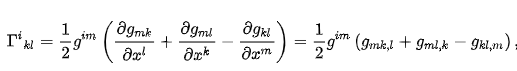

# Main Functions

In [23]:
from operator import add 
from functools import reduce
from sympy import simplify

def metric_tensor_ij(surface_vector, coords, i, j):
    coord_i=coords[i]
    coord_j=coords[j]
    
    def diff_k_map(coord): 
        diff_expr = lambda el: el.diff(coord)
        return map(diff_expr, surface_vector)
    
    f_i = diff_k_map(coord_i)
    f_j = diff_k_map(coord_j)
    
    zip_fi_fj=zip(f_i, f_j)
    zip_mul=map(lambda x: x[0]*x[1], zip_fi_fj)
    
    return simplify(reduce(add, zip_mul))

def metric_tensor(surface_vector, coords):
    from numpy import zeros
    
    n = len(coords)
    g = Matrix(zeros((n, n)))
    
    for i in range(n):
        for j in range(n):
            g[(i, j)] = metric_tensor_ij(surface_vector, coords, i, j)
    
    return g

def christoffel_i_jk(metric_tensor, metric_tensor_inv, coords, i, j, k):   
    g_shape = metric_tensor.shape
    
    if(len(g_shape) != 2):
        msg=f'A metric tensor is a 2-form with equal shape. Given dimensions ({g_shape})!'
        raise ValueError(msg)
    
    m, n = g_shape
    
    if(metric_tensor.det()==0):
        msg=f'We assume a regular metric tensor.'
        raise ValueError(msg)
    
    is_out_bounds_map=lambda index: index < 0 or index >= m
    are_indexes_out_of_bounds=is_out_bounds_map(i) or is_out_bounds_map(j) or is_out_bounds_map(k)
    
    if(are_indexes_out_of_bounds):
        condition_msg=f'Dimensions i, j, k are positive integers lesser than {m}.'
        given_msg=f'Given indexes ({i}, {j}, {k})'
        raise IndexError(f'{condition_msg} {given_msg}')
    
    gamma_i_jk = 0
    for l in range(n):
        g_inv_il = metric_tensor_inv[(i, l)]
        
        coords_j=coords[j]
        coords_k=coords[k]
        coords_l=coords[l]
        
        g_lj=metric_tensor[(l, j)]
        g_lk=metric_tensor[(l, k)]
        g_jk=metric_tensor[(j, k)]
        
        gamma_ljk = 0.5*g_lj.diff(coords_k) + g_lk.diff(coords_j) - g_jk.diff(coords_l)
        gamma_i_jk += g_inv_il*gamma_ljk
    
    return simplify(gamma_i_jk)

def christoffel_symbols(metric_tensor_, coords):
    from numpy import zeros
    
    n = len(coords)
    
    Gamma = zeros((n, n, n), dtype=object)
    metric_tensor_inv=simplify(metric_tensor_.inv())
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                Gamma[i, j, k] = christoffel_i_jk(metric_tensor_, metric_tensor_inv, coords, i, j, k)
                
    return Gamma

In [24]:
from numpy import zeros, sqrt, append, array
from scipy.integrate import solve_ivp, solve_bvp, simps
from reprlib import repr

class GeodesicCurve:
    def __init__(self, surface_vector, coordinates:tuple):
        self.surface_vector = surface_vector
        self.coordinates = coordinates
        self.metric_tensor = metric_tensor(surface_vector, self.coordinates)
        self.christoffel_symbols = christoffel_symbols(self.metric_tensor, self.coordinates)
        
        self.__n_t=0
        self.__n_y=len(coordinates)
        self.__n_dy_dt=len(coordinates)
    
    def __sizes_y_dydt(self, y_, dy_dt_):
        are_list=isinstance(y_, list) and isinstance(dy_dt_, list)
        
        if(are_list):
            n_y=len(y_)
            n_dy_dt=len(dy_dt_)
            n_t=1
        else:
            if(len(y_.shape)==1):
                n_y=len(y_)
                n_dy_dt=len(dy_dt_)
                n_t=1
            else:
                n_y, n_t=y_.shape
                n_dy_dt, n_t=dy_dt_.shape
                
        return n_t, n_y, n_dy_dt
    
    def __christoffel_ijk_value(self, i, j, k, y_t):
        n=len(self.coordinates)
        y_curr=y_t[0:n]
        
        gamma_i_jk=self.christoffel_symbols[i, j, k]
        for m in range(n_t):
            for l, coord in enumerate(self.coordinates):
                gamma_i_jk=gamma_i_jk.subs(coord, y_curr[l])
        
        return float(gamma_i_jk)
    
    def __dy2_dt2_i_jk(self, i, j, k, y_t, dy_dt_t):
        gamma_i_jk=self.__christoffel_ijk_value(i, j, k, y_t)
        if(gamma_i_jk!=0):
            dy_dt_t_j = dy_dt_t[j]
            dy_dt_t_k = dy_dt_t[k]
            gamma_ijk_value=self.__christoffel_ijk_value(i, j, k, y_t)
            
            return -gamma_ijk_value*dy_dt_t_k*dy_dt_t_j

        else:
            return 0
    
    def __dy2_dt2_i_t(self, i, t, y_t, dy_dt_t):
        n_t, n_y, n_dy_dt=self.__sizes_y_dydt(y_t, dy_dt_t)
        
        # i-th component of acceleration
        dy2_dt2_i_t=0
        
        for j in range(n_dy_dt):
            for k in range(n_dy_dt):
                dy2_dt2_i_t += self.__dy2_dt2_i_jk(i, j, k, y_t, dy_dt_t)
        
        return dy2_dt2_i_t
    
    def __dy2_dt2_i(self, i, t, y, dy_dt):
        n_t, n_y, n_dy_dt=self.__sizes_y_dydt(y, dy_dt)
        
        # i-th component of acceleration
        dy2_dt2_i=0 if n_t==1 else [0]*n_t
        
        if(n_t==1):
            y_t=y
            dy_dt_t=dy_dt
            
            dy2_dt2_i=self.__dy2_dt2_i_t(i, t, y_t, dy_dt_t)
        
        else:
            for l in range(n_t):  
                y_t=[y[m][l] for m in range(n_y)]
                dy_dt_t=[dy_dt[m][l] for m in range(n_dy_dt)]
                
                dy2_dt2_i[l]=self.__dy2_dt2_i_t(i, t, y_t, dy_dt_t)
        
        return dy2_dt2_i
    
    def __geodesic_equations(self, t, y, dy_dt):
        n_t, n_y, n_dy_dt=self.__sizes_y_dydt(y, dy_dt)
        
        # Acceleration
        dy2_dt2=[self.__dy2_dt2_i(i, t, y, dy_dt) for i in range(n_dy_dt)]
        
        dy_dt=list(dy_dt)
        dy2_dt2=list(dy2_dt2)
        
        # [Velocity, Acceleration]
        return array(dy_dt + dy2_dt2)

    def __geodesic_map(self, t, y):
        n_coords=len(self.coordinates)
        n_dy_dt=len(y)-n_coords

        y_=y[0:n_coords]
        dydt_=y[-n_dy_dt:]

        return self.__geodesic_equations(t, y_, dydt_)
    
    def inner_product(self, y_t, dy_dt_t):
        n_t, n_y, n_dy_dt=self.__sizes_y_dydt(y_t, dy_dt_t)
        
        product_val=0
        for i in range(n_dy_dt):
            for j in range(n_dy_dt):
                g_ij=self.metric_tensor[(i, j)]
                for l, coord in enumerate(self.coordinates):
                    g_ij=g_ij.subs(coord, y_t[l])
                
                g_ij=float(g_ij)
                
                product_val+=g_ij*dy_dt_t[i]*dy_dt_t[j]
                
        return product_val
    
    def solve_geodesic_ivp(self, t, y0, t_eval):   
        return solve_ivp(fun=self.__geodesic_map, t_span=t, y0=y0, t_eval=t_eval)
    
    def solve_geodesic_bvp(self, t, y0, boundary_map, max_nodes=1000):
        return solve_bvp(fun=self.__geodesic_map, bc=boundary_map, x=t, y=y0)
    
    def _velocity_norm_comb(self, t, y):
        n_coords = len(self.coordinates)
        n_dy_dt=len(y)-n_coords
        
        inner_comb=array([])
        for i in range(n_t):
            y_t = y[0:n_coords, i]
            dy_dt_t = y[-n_dy_dt:, i]
            
            inner_value=sqrt(self.inner_product(y_t, dy_dt_t))
            inner_comb=append(inner_comb, inner_value)
            
        return inner_comb
    
    def curve_length(self, curve_solution):
        t=curve_solution.t
        y=curve_solution.y
        
        inner_comb=self._velocity_norm_comb(t, y)
        
        # Integrate using Simpsons method
        length = simps(inner_comb, t)
        
        return length
    
    def __repr__(self):
        return repr(f'GeodesicCurve(surface_vector={self.surface_vector}, coordinates={self.coordinates})')

# Metric tensor and Christoffel symbols examples

In [25]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix
import numpy as np
import sympy as sp
from sympy import zeros

# Define symbols
u, v = sp.symbols('u v')

# Ellipsoid parameters: Semi-major and semi-minor axes
a, b, c = sp.symbols('a b c', positive=True)

coords_ellipsoid=(u, v)

# Eccentricity squared
lambda_squared = 1 - (b**2 / a**2)
lambda_ = sqrt(1 - lambda_squared)

# Parametric equations for the ellipsoid
x = a * cos(u) * sin(v)
y = b * sin(u) * sin(v)
z = c * cos(v)

f = [x, y, z]

g_ellipsoid = metric_tensor(f, coords_ellipsoid)

g_ellipsoid

Matrix([
[       (a**2*sin(u)**2 + b**2*cos(u)**2)*sin(v)**2,                   (-a**2 + b**2)*(cos(2*u - 2*v) - cos(2*u + 2*v))/8],
[(-a**2 + b**2)*(cos(2*u - 2*v) - cos(2*u + 2*v))/8, a**2*cos(u)**2*cos(v)**2 + b**2*sin(u)**2*cos(v)**2 + c**2*sin(v)**2]])

In [26]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
import numpy as np

# Define symbols
r, u, v = symbols('r u v')

coords_sphere = (r, u, v)

# Parametric equations for the ellipsoid
x = r * cos(u) * sin(v)
y = r * sin(u) * sin(v)
z = r * cos(v)

f = [x, y, z]

g_sphere = metric_tensor(f, coords_sphere)
g_sphere

Matrix([
[1,              0,    0],
[0, r**2*sin(v)**2,    0],
[0,              0, r**2]])

In [27]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
import numpy as np

# Define symbols
u, v = symbols('u v')

coords_sphere = (u, v)

rho = u ** 2 + v ** 2

# Parametric equations for the ellipsoid
x = rho * cos(u) * sin(v)
y = rho * sin(u) * sin(v)
z = rho * cos(v)

f = [x, y, z]

g_sphere = metric_tensor(f, coords_sphere)
g_sphere

Matrix([
[u**4*sin(v)**2 + 2*u**2*v**2*sin(v)**2 + 4*u**2 + v**4*sin(v)**2,                              4*u*v],
[                                                           4*u*v, u**4 + 2*u**2*v**2 + v**4 + 4*v**2]])

In [6]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
from IPython.display import display
import numpy as np

# Define symbols
u, v = symbols('u v')

coords_parabolic = (u, v)

# Parametric equations for the ellipsoid
x = u
y = v
z = u ** 2 + v ** 2

f = [x, y, z]

g_parabolic = metric_tensor(f, coords_parabolic)
display(g_parabolic)

christoffel_parabolic=christoffel_symbols(g_parabolic, coords_parabolic)
christoffel_parabolic

Matrix([
[4*u**2 + 1,      4*u*v],
[     4*u*v, 4*v**2 + 1]])

array([[[8*u/(4*u**2 + 4*v**2 + 1), 0],
        [0, 8*u/(4*u**2 + 4*v**2 + 1)]],

       [[8*v/(4*u**2 + 4*v**2 + 1), 0],
        [0, 8*v/(4*u**2 + 4*v**2 + 1)]]], dtype=object)

In [5]:
from numpy import zeros

Gamma = christoffel_symbols(g_sphere, coords_sphere)

# Display the simplified Christoffel symbols with upper indices
print("Gamma^r_rr:", Gamma[0, 0, 0])
print("Gamma^r_ru:", Gamma[0, 0, 1])
print("Gamma^r_rv:", Gamma[0, 0, 2])
print("Gamma^r_ur:", Gamma[0, 1, 0])
print("Gamma^r_uu:", Gamma[0, 1, 1])
print("Gamma^r_uv:", Gamma[0, 1, 2])
print("Gamma^r_vr:", Gamma[0, 2, 0])
print("Gamma^r_vu:", Gamma[0, 2, 1])
print("Gamma^r_vv:", Gamma[0, 2, 2])

print("Gamma^u_rr:", Gamma[1, 0, 0])
print("Gamma^u_ru:", Gamma[1, 0, 1])
print("Gamma^u_rv:", Gamma[1, 0, 2])
print("Gamma^u_ur:", Gamma[1, 1, 0])
print("Gamma^u_uu:", Gamma[1, 1, 1])
print("Gamma^u_uv:", Gamma[1, 1, 2])
print("Gamma^u_vr:", Gamma[1, 2, 0])
print("Gamma^u_vu:", Gamma[1, 2, 1])
print("Gamma^u_vv:", Gamma[1, 2, 2])

print("Gamma^v_rr:", Gamma[2, 0, 0])
print("Gamma^v_ru:", Gamma[2, 0, 1])
print("Gamma^v_rv:", Gamma[2, 0, 2])
print("Gamma^v_ur:", Gamma[2, 1, 0])
print("Gamma^v_uu:", Gamma[2, 1, 1])
print("Gamma^v_uv:", Gamma[2, 1, 2])
print("Gamma^v_vr:", Gamma[2, 2, 0])
print("Gamma^v_vu:", Gamma[2, 2, 1])
print("Gamma^v_vv:", Gamma[2, 2, 2])

Gamma^r_rr: 0
Gamma^r_ru: 0
Gamma^r_rv: 0
Gamma^r_ur: 0
Gamma^r_uu: -2*r*sin(v)**2
Gamma^r_uv: 0
Gamma^r_vr: 0
Gamma^r_vu: 0
Gamma^r_vv: -2*r
Gamma^u_rr: 0
Gamma^u_ru: 2/r
Gamma^u_rv: 0
Gamma^u_ur: 2/r
Gamma^u_uu: 0
Gamma^u_uv: 2/tan(v)
Gamma^u_vr: 0
Gamma^u_vu: 2/tan(v)
Gamma^u_vv: 0
Gamma^v_rr: 0
Gamma^v_ru: 0
Gamma^v_rv: 2/r
Gamma^v_ur: 0
Gamma^v_uu: -sin(2*v)
Gamma^v_uv: 0
Gamma^v_vr: 2/r
Gamma^v_vu: 0
Gamma^v_vv: 0


In [6]:
from numpy import zeros

Gamma = christoffel_symbols(g_ellipsoid, coords_ellipsoid)

# Display the simplified Christoffel symbols with upper indices
print("Gamma^u_uu:", Gamma[0, 0, 0])
print("Gamma^u_uv:", Gamma[0, 0, 1])
print("Gamma^u_vu:", Gamma[0, 1, 0])
print("Gamma^u_vv:", Gamma[0, 1, 1])

print("Gamma^v_uu:", Gamma[1, 0, 0])
print("Gamma^v_uv:", Gamma[1, 0, 1])
print("Gamma^v_vu:", Gamma[1, 1, 0])
print("Gamma^v_vv:", Gamma[1, 1, 1])

Gamma^u_uu: c**2*(-3 + sin(3*v)/sin(v))*(a**2 - b**2)*sin(u)*cos(u)/(2*(a**2*b**2*sin(v)**2 - a**2*b**2 - a**2*c**2*sin(u)**2*sin(v)**2 + b**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(v)**2))
Gamma^u_uv: (-2*(a**2 - b**2)**2*(2*sin(2*v) + sin(4*u - 2*v) - sin(4*u + 2*v)) + 64*(a**2*sin(u)**2 + b**2*cos(u)**2)*(a**2*cos(u)**2*cos(v)**2 + b**2*sin(u)**2*cos(v)**2 + c**2*sin(v)**2)*tan(v))/(32*(-a**2*b**2*sin(v)**2 + a**2*b**2 + a**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(u)**2*sin(v)**2 + b**2*c**2*sin(v)**2)*tan(v)**2)
Gamma^u_vu: (-2*(a**2 - b**2)**2*(2*sin(2*v) + sin(4*u - 2*v) - sin(4*u + 2*v)) + 64*(a**2*sin(u)**2 + b**2*cos(u)**2)*(a**2*cos(u)**2*cos(v)**2 + b**2*sin(u)**2*cos(v)**2 + c**2*sin(v)**2)*tan(v))/(32*(-a**2*b**2*sin(v)**2 + a**2*b**2 + a**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(u)**2*sin(v)**2 + b**2*c**2*sin(v)**2)*tan(v)**2)
Gamma^u_vv: 2*c**2*(a**2 - b**2)*sin(u)*cos(u)/(-a**2*b**2*sin(v)**2 + a**2*b**2 + a**2*c**2*sin(u)**2*sin(v)**2 - b**2*c**2*sin(u)**2*sin(v

# Initial and boundary value problems

In [28]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
from numpy import array, zeros, linspace, concatenate, arcsinh

# Define symbols
u, v = symbols('u v')

coords_parabolic = (u, v)

# Parametric equations for the ellipsoid
x = u
y = v
z = u ** 2 + v ** 2

f = [x, y, z]

max_nodes=500

x=linspace(0, 1, max_nodes)
n = len(x)

vel=float((2*sqrt(5)+arcsinh(2))/4)

p0=array([0, 0])
v0=array([vel, 0])

y0=concatenate([p0, v0])

n_t = len(x)
n_y = len(y0)

curve_obj = GeodesicCurve(f, coords_parabolic)

solution=curve_obj.solve_geodesic_ivp([0, 1], y0, x)
curve_obj.curve_length(solution)


1.47875528371255

In [29]:
f = curve_obj.surface_vector
t = solution.t
y = solution.y[2:4, :]


In [30]:
curve_obj.curve_length(solution)

1.47875528371255

In [31]:
from numpy import append

f = curve_obj.surface_vector
t = solution.t
y = solution.y[0:2, :]

points=[]
for i, t_i in enumerate(t):
    point=zeros(3)
    for k, f_k in enumerate(f):
        f_k_ = f_k
        for l, coord in enumerate(curve_obj.coordinates):
            f_k_ = f_k_.subs(coord, y[l, i])
        
        point[k]=float(f_k_)
    
    points.append(point)

points=array(points).T


In [32]:
from numpy import append

t = solution.t
f = curve_obj.surface_vector
y = solution.y[0:2, :]

points=[]
for i, t_i in enumerate(t):
    point=zeros(3)
    for k, f_k in enumerate(f):
        f_k_ = f_k
        for l, coord in enumerate(curve_obj.coordinates):
            f_k_ = f_k_.subs(coord, y[l, i])
        
        point[k]=float(f_k_)
    
    points.append(point)

points=array(points).T


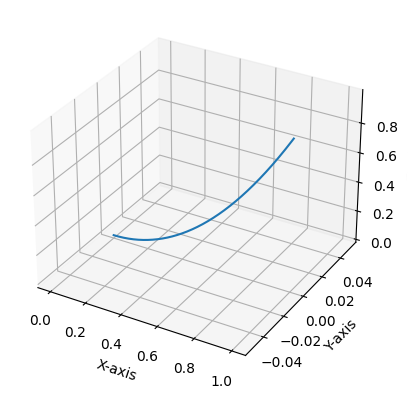

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create data for the 3D curve
t = solution.t
x = points[0, :]
y = points[1, :]
z = points[2, :]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D curve
ax.plot(x, y, z)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show the plot
plt.show()

In [5]:
from sympy import cos, sin, sqrt, Matrix, ZeroMatrix, symbols
from numpy import array, zeros, linspace, concatenate

# Define symbols
u, v = symbols('u v')

coords_parabolic = (u, v)

# Parametric equations for the ellipsoid
x = u
y = v
z = u ** 2 + v ** 2

f = [x, y, z]

max_nodes=100

x=linspace(0, 1, max_nodes)
n = len(x)

pa=array([-1, -1])
pb=array([1, 1])
va=pb-pa
vb=va

ya=concatenate([pa, va])
yb=concatenate([pb, vb])

x=linspace(0, 1, max_nodes)

n_t = len(x)
n_y = len(ya)

y0=array([[0]*n_t for i in range(n_y)])

for i in range(n_y):
    y0[i, 0] = ya[i]
    y0[i, -1] = yb[i]

ya_=[[el]*n for el in ya]
yb_=[[el]*n for el in yb]

def boundary_map(ya, yb):
    from numpy import concatenate, array
    return array([
        ya[0]-ya[0], ya[1]-ya[1],
        yb[0]-yb[0], yb[1]-yb[1],
     ])

curve_obj = GeodesicCurve(f, coords_parabolic)

solution=curve_obj.solve_geodesic_bvp(x, y0, boundary_map)


[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.

AttributeError: 'list' object has no attribute 'shape'

In [37]:
from spycio import distance

A=[0, 0]
D=[np.pi / 2, 0]

method="sphere"
config={ "radius": 1 }

distance(A, D, method, config)

1.5707963267948966

In [45]:
from scipy.optimize import minimize
from numpy import sin, cos, vstack, array, linspace, diff, sqrt, arcsin
from numpy.linalg import norm
import numpy

class Ellipsoid:
    def __init__(self, a=1, b=1, c=1):
        self.abc = [a,b,c]
    
    def point(self, theta, phi):
        '''
            Point over a Ellipsoid with phi=0 at the equator, 
            and at the poles +pi/2 and -pi/2
        '''
        c_phi=cos(phi)
        s_phi=sin(phi)
        c_theta=cos(theta)
        s_theta=sin(theta)
        
        a, b, c = self.abc
        
        return a * c_phi * c_theta, b * c_phi * s_theta, c * s_phi
    
    def euclidian(self, p0, p1):
        return norm(p1-p0)
    
    def _discretized_path_length(self, path):
        theta, phi = vstack(path).T
        dist_2=sum(diff(w)**2 for w in self.point(theta, phi))
        
        return sqrt(dist_2).sum()
    
    def _discretized_packed_path_length(self, inner_path, p0, p1):
        '''
            Interface to scipy minimization:
                - Take a packed array with the parametized path, and two extra
                arguments, p0 the initiala point parameters, and p1 the final point parameters.
        '''
        path=[[p0], inner_path.reshape(-1, 2), [p1]]
        
        return self._discretized_path_length(path)
    
    def geodesic(self, p1, p2, n, method='least_squares'):
        '''
            Given p1=(theta1, phi1), p2=(theta1, phi2) and a number
            of segments computes the discretized geodesic
        '''
        theta1, phi1 = p1
        theta2, phi2 = p2
        
        thetas = linspace(theta1, theta2, n+1)
        phis = linspace(phi1, phi2, n+1)
        coords = array([thetas, phis]).T
        
        results = minimize(
            fun=self._discretized_packed_path_length,
            x0=coords[1:-1].reshape(-1),
            args=(coords[0], coords[-1])
        )

        coords[1:-1] = results.x.reshape(-1, 2)
        thetas, phis = coords.T
        
        return thetas, phis

def check_geodesic(ball, p0, p1, n, is_verbose=False):
    thetas, phis = zip(p0, p1)

    theta0 = np.linspace(*thetas, n+1)
    phi0 = np.linspace(*phis, n+1)
    path_0=list(zip(theta0, phi0))

    initial_length = ball._discretized_path_length(path_0)
    
    thetas, phis = ball.geodesic(p0, p1, n)
    path_=array(list(zip(thetas, phis)))
    
    m_geodesic_length = ball._discretized_path_length(path_)

    if(is_verbose):
        print('Initial point: '+str((p0[0], p0[-1],)))
        print('Final point: '+str((p1[0], p1[-1],)))
        print()
        print('Initial path length:', initial_length)
        print('Geodesic length (minimize):', m_geodesic_length)


In [47]:
import matplotlib.pyplot as plt

n=100
p0=(0, 0)
p1=(0, np.pi/2)

n=10
step_sizes=100*array(linspace(1, n, n))

ball = Ellipsoid(1,1,1)
check_geodesic(ball, p0, p1, int(n), True)



Initial point: (0, 0)
Final point: (0, 1.5707963267948966)

Initial path length: 1.5691819145568988
Geodesic length (minimize): 1.5691819145568988
